In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading data
df = pd.read_csv('./clean_credit_card_fraud_dataset.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

# Train/Test Split
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Defining a function to create the pipeline
def make_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler()),  # Standardize
        ('model', model)               # Model
    ])

In [4]:
# Defining models
# Logistic Regression
lr_pipeline = make_pipeline(LogisticRegression(max_iter=1000))
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

In [5]:
# Random Forest
rf_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [6]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# SVM
base_svm = LinearSVC(max_iter=1000, random_state=42)
svm_pipeline = make_pipeline(CalibratedClassifierCV(base_svm, cv=3))
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

In [7]:
# LightGBM
lgb_pipeline = make_pipeline(LGBMClassifier(random_state=42))
lgb_pipeline.fit(X_train, y_train)
y_pred_lgb = lgb_pipeline.predict(X_test)
y_proba_lgb = lgb_pipeline.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 6558, number of negative: 5083525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 5090083, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001288 -> initscore=-6.653075
[LightGBM] [Info] Start training from score -6.653075


In [8]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# XGBoost
xgb_pipeline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_pipeline.fit(scaler.fit_transform(imputer.fit_transform(X_train)), y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [9]:
# Collecting results

def get_metrics(y_true, y_pred, y_proba):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'MSE': mse,
        'RMSE': rmse
    }

results = []

results.append({'Model': 'Logistic Regression', **get_metrics(y_test, y_pred_lr, y_proba_lr)})
results.append({'Model': 'Random Forest', **get_metrics(y_test, y_pred_rf, y_proba_rf)})
results.append({'Model': 'XGBoost', **get_metrics(y_test, y_pred_xgb, y_proba_xgb)})
results.append({'Model': 'SVM', **get_metrics(y_test, y_pred_svm, y_proba_svm)})
results.append({'Model': 'LightGBM', **get_metrics(y_test, y_pred_lgb, y_proba_lgb)})

# Creating and displaying the final results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df.sort_values(by='F1 Score', ascending=False))



Model Comparison Results:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
1        Random Forest  0.999696   0.961652  0.795607  0.870785  0.994368   
3                  SVM  0.999319   0.903024  0.528371  0.666667  0.987736   
0  Logistic Regression  0.999332   0.955017  0.505186  0.660814  0.988324   
4             LightGBM  0.998728   0.504921  0.625991  0.558976  0.810391   
2              XGBoost  0.724071   0.003949  0.848688  0.007861  0.811999   

        MSE      RMSE  
1  0.000304  0.017439  
3  0.000681  0.026087  
0  0.000668  0.025845  
4  0.001272  0.035669  
2  0.275929  0.525290  


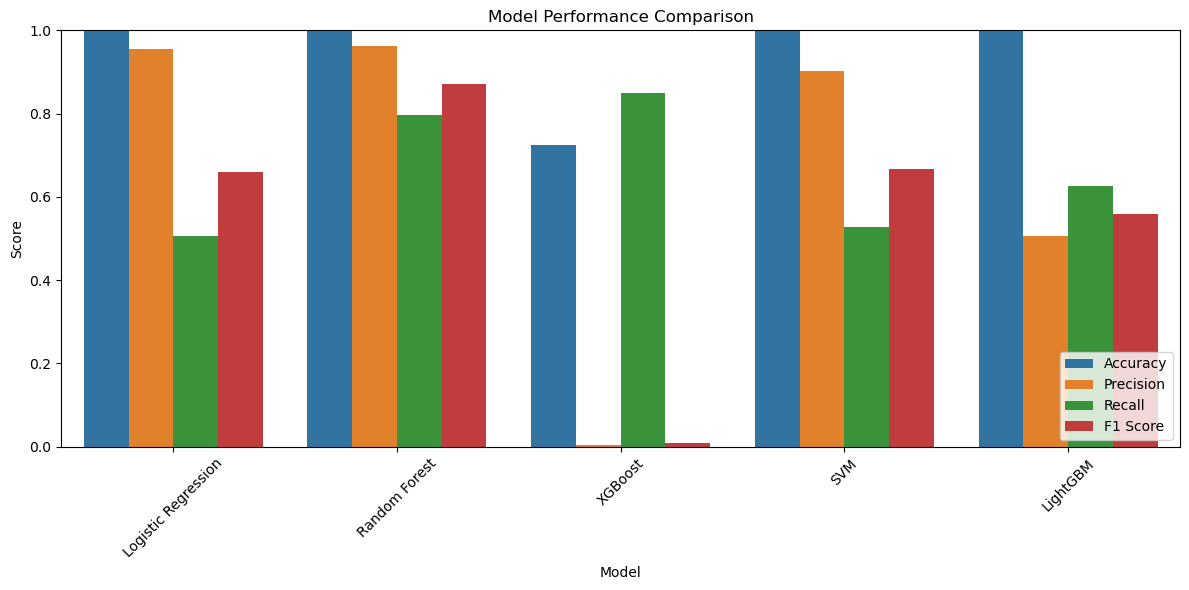

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

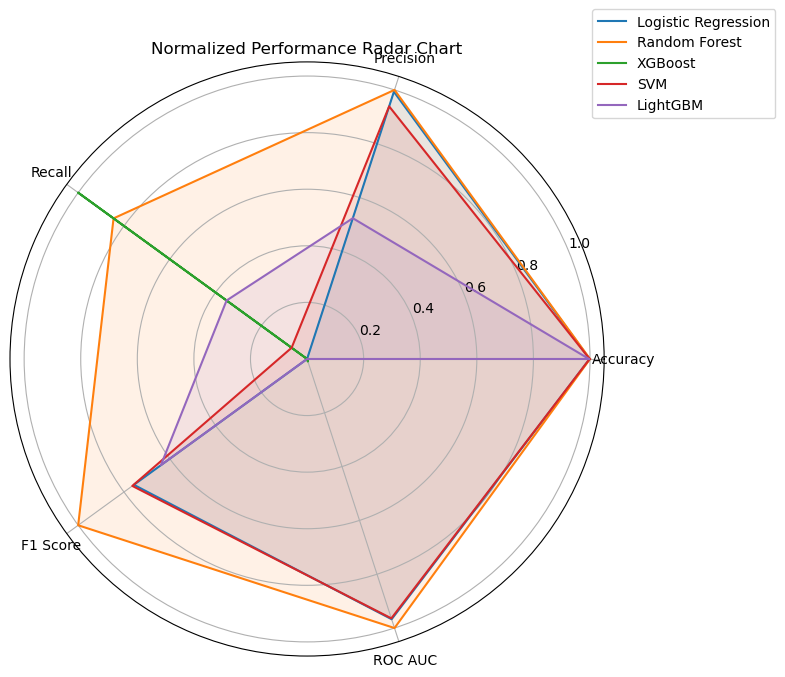

In [11]:
from math import pi

# Normalize all performance metrics to [0,1] scale
radar_data = results_df.copy()
radar_data.set_index('Model', inplace=True)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
radar_normalized = (radar_data[metrics] - radar_data[metrics].min()) / (radar_data[metrics].max() - radar_data[metrics].min())

# Radar chart setup
labels = radar_normalized.columns.tolist()
num_vars = len(labels)

plt.figure(figsize=(8, 8))
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

for model in radar_normalized.index:
    values = radar_normalized.loc[model].tolist()
    values += values[:1]  # Close the loop
    plt.polar(angles, values, label=model)
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], labels)
plt.title('Normalized Performance Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

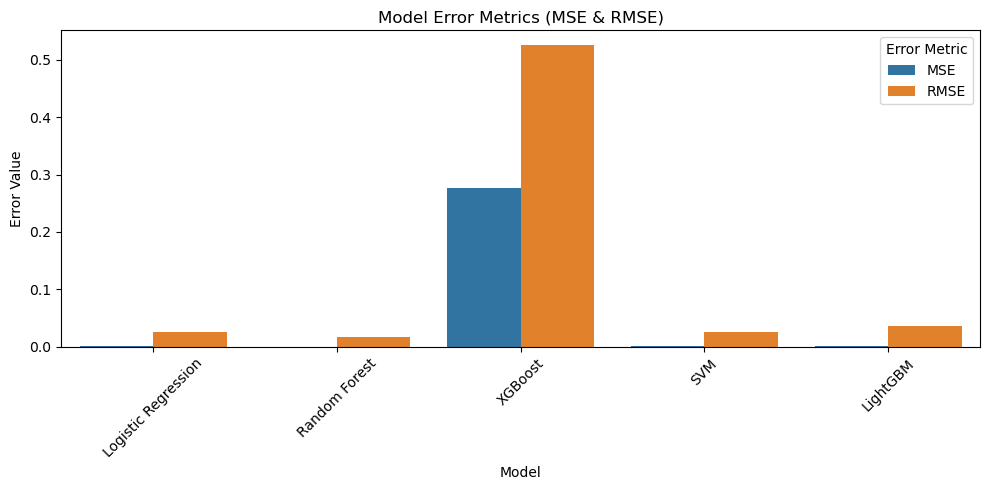

In [12]:
mse_rmse = results_df[['Model', 'MSE', 'RMSE']].melt(id_vars='Model', var_name='Error Metric', value_name='Error Value')

plt.figure(figsize=(10, 5))
sns.barplot(data=mse_rmse, x='Model', y='Error Value', hue='Error Metric')
plt.title('Model Error Metrics (MSE & RMSE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

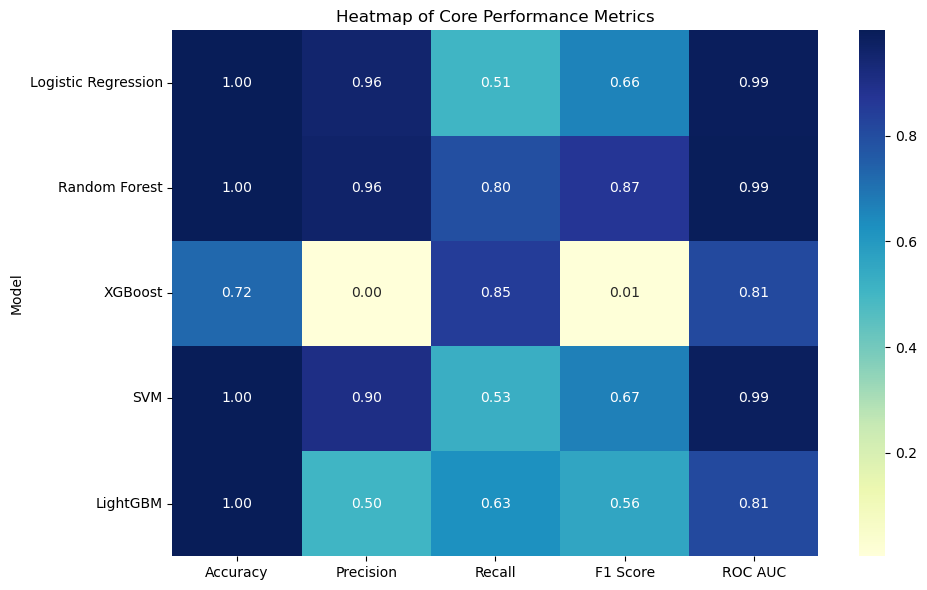

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.set_index('Model')[metrics], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Heatmap of Core Performance Metrics')
plt.tight_layout()
plt.show()

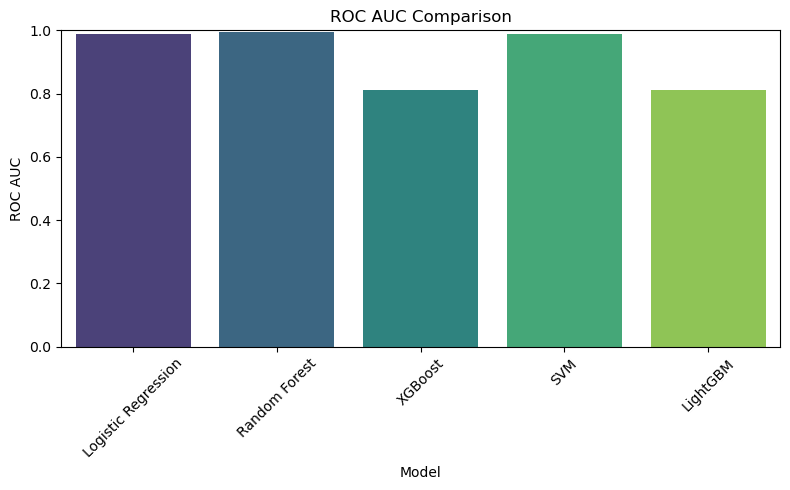

In [14]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='ROC AUC', palette='viridis')
plt.title('ROC AUC Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

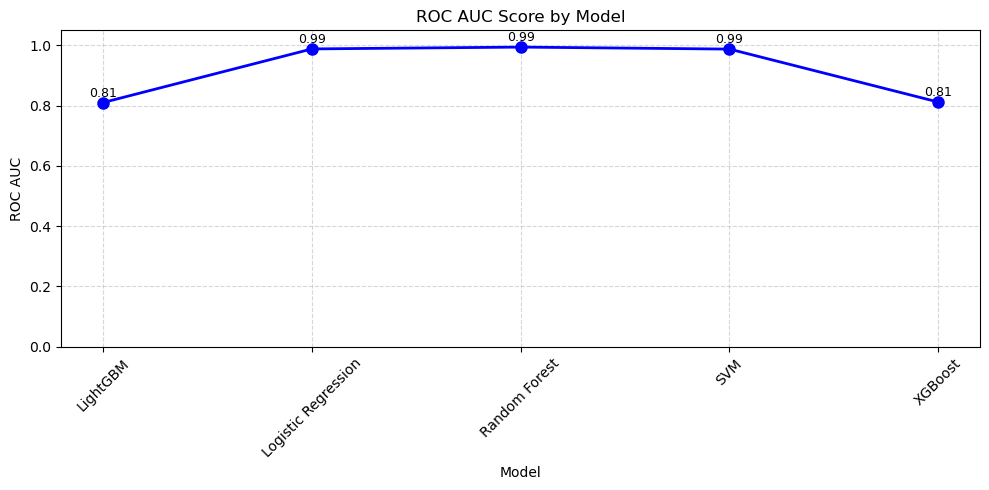

In [15]:
import matplotlib.pyplot as plt

# Sort by model name (alphabetical) or by ROC AUC
roc_sorted = results_df.sort_values(by='Model')  # or use 'ROC AUC' to sort by performance

plt.figure(figsize=(10, 5))
plt.plot(roc_sorted['Model'], roc_sorted['ROC AUC'], marker='o', linestyle='-',
         color='blue', linewidth=2, markersize=8)

# Add value labels on each point
for i, auc in enumerate(roc_sorted['ROC AUC']):
    plt.text(i, auc + 0.01, f"{auc:.2f}", ha='center', va='bottom', fontsize=9)

plt.title('ROC AUC Score by Model')
plt.xlabel('Model')
plt.ylabel('ROC AUC')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.impute import SimpleImputer
from skopt.space import Real, Integer, Categorical
import pandas as pd
import numpy as np

# Resample data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)  # Returns NumPy array, convert back if needed
X = pd.DataFrame(X_imputed, columns=X.columns)

# Apply undersampling + SMOTE
resampling_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('smote', SMOTE(sampling_strategy=0.5, k_neighbors=1, random_state=42)),
])

X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)
combined_weight_resampled = X_resampled['combined_weight']
X_resampled = X_resampled.drop(columns=['combined_weight'])

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_resampled, y_resampled, combined_weight_resampled,
    test_size=0.2, stratify=y_resampled, random_state=42
)

In [17]:
# Define helper

def evaluate_model(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'MSE': mse,
        'RMSE': rmse
    }

In [30]:
from sklearn.metrics import classification_report

# ----- Updated Evaluation Function for Overfitting/Underfitting -----
def evaluate_overfitting(model):
    # print(f"--- {model_name} ---")
    
    # Predict on train and test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities if supported
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else y_train_pred
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_test_pred

    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)

    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    
    # Compute metrics
    results = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        'Train Precision': precision_score(y_train, y_train_pred, zero_division=0),
        'Test Precision': precision_score(y_test, y_test_pred, zero_division=0),
        'Train Recall': recall_score(y_train, y_train_pred, zero_division=0),
        'Test Recall': recall_score(y_test, y_test_pred, zero_division=0),
        "Train F1": f1_score(y_train, y_train_pred, zero_division=0),
        "Test F1": f1_score(y_test, y_test_pred, zero_division=0),
        "Train ROC AUC": roc_auc_score(y_train, y_train_proba),
        "Test ROC AUC": roc_auc_score(y_test, y_test_proba),
        "Train MSE": mse_train,
        "Test MSE": mse_test,
        "Train RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }
    print(pd.Series(results), end="\n\n")
    return results


In [31]:
from sklearn.model_selection import GridSearchCV

# General model grid search function
def grid_search_pipeline(model, param_grid, model_name):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0))
    ])
    pipeline.fit(X_train, y_train)
    results = evaluate_overfitting(pipeline)
    results['Model'] = model_name
    return results

In [32]:
# --- Random Forest ---
rf_result = grid_search_pipeline(
    RandomForestClassifier(random_state=42),
    {
        "n_estimators": [100, 300],
        "max_depth": [10, 20],
        "min_samples_split": [2, 5]
    },
    "Random Forest"
)

Train Accuracy     0.999817
Test Accuracy      0.996706
Train Precision    0.999939
Test Precision     0.993914
Train Recall       0.999512
Test Recall        0.996218
Train F1           0.999725
Test F1            0.995065
Train ROC AUC      1.000000
Test ROC AUC       0.999920
Train MSE          0.000183
Test MSE           0.003294
Train RMSE         0.013528
Test RMSE          0.057392
dtype: float64



In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
# --- LightGBM ---
lgb_result = grid_search_pipeline(
    LGBMClassifier(random_state=42),
    {
        "num_leaves": [31, 50],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200]
    },
    "LightGBM"
)

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

[LightGBM] [Info] Number of positive: 32788, number of negative: 65576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 98364, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Train Accuracy     0.999807
Test Accuracy      0.996950
Train Precision    0.999665
Test Precision     0.993799
Train Recall       0.999756
Test Recall        0.997072
Train F1           0.999710
Test F1            0.995433
Train ROC AUC      1.000000
Test ROC AUC       0.999901
Train MSE          0.000193
Test MSE           0.003050
Train RMSE         0.013898
Test RMSE          0.055226
dtype: float64



In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- Gradient Boosting ---
gb_result = grid_search_pipeline(
    GradientBoostingClassifier(random_state=42),
    {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 6]
    },
    "Gradient Boosting"
)

Train Accuracy     0.998272
Test Accuracy      0.994917
Train Precision    0.996046
Test Precision     0.989806
Train Recall       0.998780
Test Recall        0.994998
Train F1           0.997411
Test F1            0.992395
Train ROC AUC      0.999957
Test ROC AUC       0.999407
Train MSE          0.001728
Test MSE           0.005083
Train RMSE         0.041573
Test RMSE          0.071296
dtype: float64



In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- HistGradientBoosting ---
hgb_result = grid_search_pipeline(
    HistGradientBoostingClassifier(random_state=42),
    {
        "learning_rate": [0.01, 0.1],
        "max_iter": [100, 200],
        "max_depth": [3, 6]
    },
    "HistGradientBoosting"
)

Train Accuracy     0.996859
Test Accuracy      0.995527
Train Precision    0.993887
Test Precision     0.990895
Train Recall       0.996706
Test Recall        0.995730
Train F1           0.995295
Test F1            0.993307
Train ROC AUC      0.999912
Test ROC AUC       0.999810
Train MSE          0.003141
Test MSE           0.004473
Train RMSE         0.056048
Test RMSE          0.066882
dtype: float64



In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
# --- XGBoost ---
xgb_result = grid_search_pipeline(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    {
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "XGBoost"
)

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

Train Accuracy     0.996411
Test Accuracy      0.995689
Train Precision    0.992978
Test Precision     0.991018
Train Recall       0.996279
Test Recall        0.996096
Train F1           0.994626
Test F1            0.993551
Train ROC AUC      0.999910
Test ROC AUC       0.999833
Train MSE          0.003589
Test MSE           0.004311
Train RMSE         0.059906
Test RMSE          0.065655
dtype: float64



In [37]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
# --- SGDClassifier ---
sgd_result = grid_search_pipeline(
    SGDClassifier(loss='log_loss', random_state=42),
    {
        "alpha": [1e-4, 1e-2],
        "penalty": ['l1', 'l2'],
        "max_iter": [1000, 1500]
    },
    "SGDClassifier"
)

/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: d

Train Accuracy     0.961449
Test Accuracy      0.964215
Train Precision    0.949690
Test Precision     0.953402
Train Recall       0.933817
Test Recall        0.938514
Train F1           0.941687
Test F1            0.945899
Train ROC AUC      0.992153
Test ROC AUC       0.993333
Train MSE          0.038551
Test MSE           0.035785
Train RMSE         0.196343
Test RMSE          0.189170
dtype: float64



In [38]:
# Compile and display results
grid_results_df = pd.DataFrame([
    rf_result, lgb_result, gb_result,
    hgb_result, xgb_result, sgd_result
])

# print(grid_results_df.sort_values(by="F1 Score", ascending=False))

In [39]:
# Format results into a DataFrame
columns = [
    'Model',
    'Accuracy_train', 'Precision_train', 'Recall_train', 'F1_train', 'ROC AUC_train', 'MSE_train', 'RMSE_train',
    'Accuracy_test',  'Precision_test',  'Recall_test',  'F1_test',  'ROC AUC_test',  'MSE_test',  'RMSE_test'
]
grid_results = pd.DataFrame(grid_results_df, columns=columns)
print("\nTraining vs Test Performance Comparison:")
print(grid_results)


Training vs Test Performance Comparison:
                  Model  Accuracy_train  Precision_train  Recall_train  \
0         Random Forest             NaN              NaN           NaN   
1              LightGBM             NaN              NaN           NaN   
2     Gradient Boosting             NaN              NaN           NaN   
3  HistGradientBoosting             NaN              NaN           NaN   
4               XGBoost             NaN              NaN           NaN   
5         SGDClassifier             NaN              NaN           NaN   

   F1_train  ROC AUC_train  MSE_train  RMSE_train  Accuracy_test  \
0       NaN            NaN        NaN         NaN            NaN   
1       NaN            NaN        NaN         NaN            NaN   
2       NaN            NaN        NaN         NaN            NaN   
3       NaN            NaN        NaN         NaN            NaN   
4       NaN            NaN        NaN         NaN            NaN   
5       NaN            NaN     

In [ ]:
# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
grid_results_melted = grid_results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=grid_results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from skopt import BayesSearchCV

# General model bayes search function
def bayes_search_pipeline(base_model, search_space, name):
    search = BayesSearchCV(
        estimator=base_model,
        search_spaces=search_space,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    if hasattr(base_model, 'predict_proba'):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', search)
        ])
    else:
        # Skip scaler if not needed
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', search)
        ])
    
    pipeline.fit(X_train, y_train)
    result = evaluate_overfitting(pipeline)
    result['Model'] = name
    return result

In [ ]:
# --- Random Forest ---
rf_result = bayes_search_pipeline(
    RandomForestClassifier(random_state=42),
    {
        "n_estimators": Integer(100, 500),
        "max_depth": Integer(5, 30),
        "min_samples_split": Integer(2, 10)
    },
    "Random Forest"
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- LightGBM ---
lgb_result = bayes_search_pipeline(
    LGBMClassifier(random_state=42),
    {
        "num_leaves": Integer(20, 100),
        "learning_rate": Real(0.01, 0.3, prior='log-uniform'),
        "n_estimators": Integer(100, 300)
    },
    "LightGBM"
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- Gradient Boosting ---
ggb_result = bayes_search_pipeline(
    GradientBoostingClassifier(random_state=42),
    {
        "n_estimators": Integer(100, 300),
        "learning_rate": Real(0.01, 0.2, prior='log-uniform'),
        "max_depth": Integer(3, 10)
    },
    "Gradient Boosting"
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- HistGradientBoosting ---
hgb_result = bayes_search_pipeline(
    HistGradientBoostingClassifier(random_state=42),
    {
        "learning_rate": Real(0.01, 0.2, prior='log-uniform'),
        "max_iter": Integer(100, 300),
        "max_depth": Integer(3, 10)
    },
    "HistGradientBoosting"
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# --- SGDClassifier ---
sgd_result = bayes_search_pipeline(
    SGDClassifier(loss='log_loss', random_state=42),
    {
        "alpha": Real(1e-5, 1e-1, prior='log-uniform'),
        "penalty": Categorical(['l1', 'l2']),
        "max_iter": Integer(500, 2000)
    },
    "SGDClassifier"
)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
# --- XGBoost ---
xgb_result = bayes_search_pipeline(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    {
        "learning_rate": Real(0.01, 0.3, prior='log-uniform'),
        "n_estimators": Integer(100, 300),
        "max_depth": Integer(3, 10),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0)
    },
    "XGBoost"
)

In [ ]:
# Compile results
bayes_results_df = pd.DataFrame([
    rf_result,
    lgb_result,
    gb_result,
    hgb_result,
    xgb_result,
    sgd_result
])

print(bayes_results_df.sort_values(by="F1 Score", ascending=False))

In [ ]:
# Melt the DataFrame for better plotting
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bayes_results_melted = bayes_results_df.melt(id_vars='Model', value_vars=metrics_to_plot,
                                 var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=bayes_results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Format results into a DataFrame
columns = [
    'Model',
    'Accuracy_train', 'Precision_train', 'Recall_train', 'F1_train', 'ROC AUC_train', 'MSE_train', 'RMSE_train',
    'Accuracy_test',  'Precision_test',  'Recall_test',  'F1_test',  'ROC AUC_test',  'MSE_test',  'RMSE_test'
]
bayes_results = pd.DataFrame(bayes_results_df, columns=columns)
print("\nTraining vs Test Performance Comparison:")
print(bayes_results)

[LightGBM] [Info] Number of positive: 21859, number of negative: 43717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 65576, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333338 -> initscore=-0.693124
[LightGBM] [Info] Start training from score -0.693124
[LightGBM] [Info] Number of positive: 21859, number of negative: 43717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 65576, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333338 -> initscore=-0.693124
[LightGBM] [Info] Start training from score -0.693124
[LightGBM] [